<a href="https://colab.research.google.com/github/Vaibhav807/Artificial-Intelligence-Projects/blob/main/Image_Compression_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define a transform to normalize the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Download and load the training data
trainset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

# Verify data loading
dataiter = iter(trainloader)
images, labels = next(dataiter)

print(f'Train Images Batch Shape: {images.shape}')
print(f'Train Labels Batch Shape: {labels.shape}')

100%|██████████| 26421880/26421880 [00:00<00:00, 102395288.67it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 5711149.78it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw




100%|██████████| 4422102/4422102 [00:00<00:00, 11269653.07it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 5802815.64it/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

Train Images Batch Shape: torch.Size([64, 1, 28, 28])
Train Labels Batch Shape: torch.Size([64])


In [11]:
# Check GPU availability and type
if torch.cuda.is_available():
    print("CUDA is available.")
    gpu_name = torch.cuda.get_device_name(0)
    print("Device name:", gpu_name)
    if "T4" in gpu_name:
        print("Tesla T4 GPU is in use.")
    else:
        print("The GPU in use is not a Tesla T4.")
else:
    print("CUDA is not available.")

CUDA is available.
Device name: Tesla T4
Tesla T4 GPU is in use.


In [2]:
# Autoencoder Model
class CompressionAutoencoder(nn.Module):
    def __init__(self):
        super(CompressionAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64,32)
        )
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 28*28),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.encoder(x)
        x = self.decoder(x)
        x = x.view(-1, 1, 28, 28)
        return x

In [3]:
import matplotlib.pyplot as plt

# Initialize lists to store loss values
train_losses = []
val_losses = []

# Hyperparameters
batch_size = 64
learning_rate = 0.001
num_epochs = 10

model = CompressionAutoencoder()


In [12]:
def training(num_epochs, initial_learning_rate):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=initial_learning_rate)

    train_losses = []
    val_losses = []
    increase_counter = 0
    best_loss = float('inf')
    learning_rate = initial_learning_rate

    # Move model to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, _ in trainloader:
            images = images.to(device)  # Move images to GPU
            noisy_images = images  # Noisy images are already added in the transformation

            # Forward pass
            outputs = model(noisy_images)
            loss = criterion(outputs, images)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)

        epoch_loss = running_loss / len(trainloader.dataset)
        train_losses.append(epoch_loss)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

        # Check if the loss has increased
        if epoch_loss > best_loss:
            increase_counter += 1
        else:
            increase_counter = 0
            best_loss = epoch_loss

        # Adjust learning rate if the loss increased 3 times consecutively
        if increase_counter >= 3:
            learning_rate /= 10
            for param_group in optimizer.param_groups:
                param_group['lr'] = learning_rate
            print(f'Learning rate adjusted to {learning_rate}')
            increase_counter = 0

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, _ in testloader:
                images = images.to(device)  # Move images to GPU
                noisy_images = images
                outputs = model(noisy_images)
                loss = criterion(outputs, images)
                val_loss += loss.item() * images.size(0)

        val_loss /= len(testloader.dataset)
        val_losses.append(val_loss)
        print(f'Validation Loss: {val_loss:.4f}')

    # Plotting the loss values
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
    plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()


In [17]:
def visualize_results(model, data_loader, num_images=20, device='cuda'):
    model.to(device)
    model.eval()
    with torch.no_grad():
        for images, _ in data_loader:
            noisy_images = images.to(device)
            outputs = model(noisy_images)
            break

    # Plot original noisy images and denoised images
    fig, axes = plt.subplots(2, num_images, figsize=(num_images*2, 4))
    for i in range(num_images):
        # Noisy images
        ax = axes[0, i]
        ax.imshow(noisy_images[i].view(28, 28).cpu(), cmap='gray')
        ax.axis('off')
        # Denoised images
        ax = axes[1, i]
        ax.imshow(outputs[i].view(28, 28).cpu(), cmap='gray')
        ax.axis('off')
    plt.show()

Epoch [1/50], Loss: 0.6153
Validation Loss: 0.6032
Epoch [2/50], Loss: 0.6031
Validation Loss: 0.5992
Epoch [3/50], Loss: 0.6001
Validation Loss: 0.5967
Epoch [4/50], Loss: 0.5978
Validation Loss: 0.5945
Epoch [5/50], Loss: 0.5961
Validation Loss: 0.5931
Epoch [6/50], Loss: 0.5950
Validation Loss: 0.5924
Epoch [7/50], Loss: 0.5940
Validation Loss: 0.5917
Epoch [8/50], Loss: 0.5933
Validation Loss: 0.5909
Epoch [9/50], Loss: 0.5928
Validation Loss: 0.5903
Epoch [10/50], Loss: 0.5923
Validation Loss: 0.5901
Epoch [11/50], Loss: 0.5918
Validation Loss: 0.5896
Epoch [12/50], Loss: 0.5915
Validation Loss: 0.5892
Epoch [13/50], Loss: 0.5912
Validation Loss: 0.5889
Epoch [14/50], Loss: 0.5908
Validation Loss: 0.5887
Epoch [15/50], Loss: 0.5906
Validation Loss: 0.5887
Epoch [16/50], Loss: 0.5903
Validation Loss: 0.5883
Epoch [17/50], Loss: 0.5901
Validation Loss: 0.5884
Epoch [18/50], Loss: 0.5899
Validation Loss: 0.5882
Epoch [19/50], Loss: 0.5897
Validation Loss: 0.5876
Epoch [20/50], Loss: 

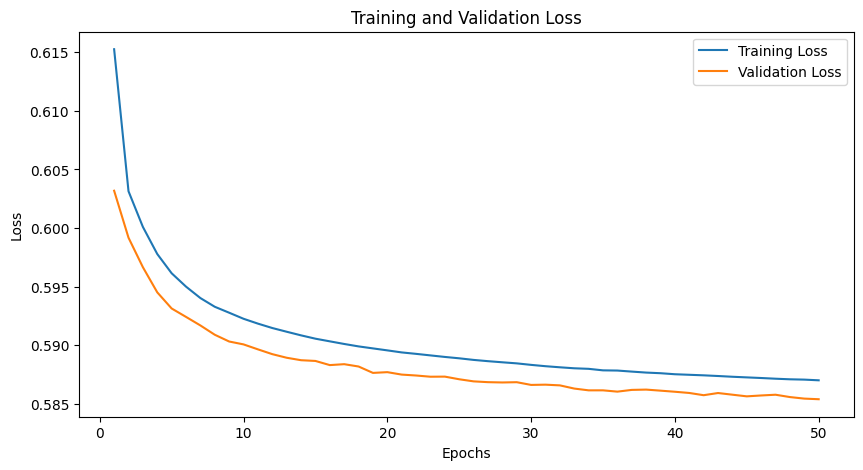

In [14]:
training(50, 0.001)

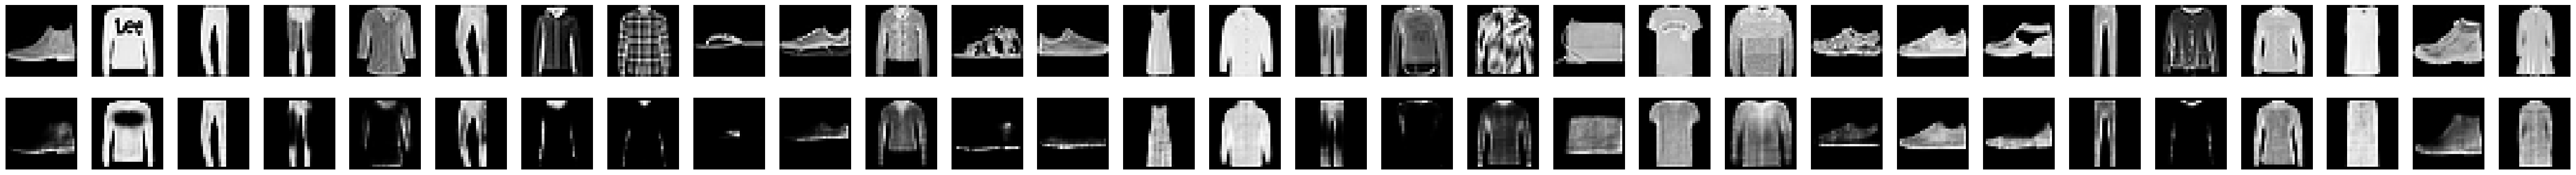

In [19]:
# Visualize the results on test data
visualize_results(model, testloader, 30)

In [16]:
torch.save(model.state_dict(), "image_compression_autoencoder.pt")
model.load_state_dict(torch.load("image_compression_autoencoder.pt"))

<All keys matched successfully>

Epoch [1/30], Loss: 0.5859
Validation Loss: 0.5846
Epoch [2/30], Loss: 0.5858
Validation Loss: 0.5845
Epoch [3/30], Loss: 0.5857
Validation Loss: 0.5845
Epoch [4/30], Loss: 0.5857
Validation Loss: 0.5845
Epoch [5/30], Loss: 0.5857
Validation Loss: 0.5845
Epoch [6/30], Loss: 0.5856
Validation Loss: 0.5845
Epoch [7/30], Loss: 0.5856
Validation Loss: 0.5845
Epoch [8/30], Loss: 0.5856
Validation Loss: 0.5844
Epoch [9/30], Loss: 0.5856
Validation Loss: 0.5844
Epoch [10/30], Loss: 0.5856
Validation Loss: 0.5845
Epoch [11/30], Loss: 0.5856
Validation Loss: 0.5844
Epoch [12/30], Loss: 0.5855
Validation Loss: 0.5844
Epoch [13/30], Loss: 0.5855
Validation Loss: 0.5844
Epoch [14/30], Loss: 0.5855
Validation Loss: 0.5844
Epoch [15/30], Loss: 0.5855
Validation Loss: 0.5844
Epoch [16/30], Loss: 0.5855
Validation Loss: 0.5844
Epoch [17/30], Loss: 0.5855
Validation Loss: 0.5844
Epoch [18/30], Loss: 0.5855
Validation Loss: 0.5844
Epoch [19/30], Loss: 0.5855
Validation Loss: 0.5844
Epoch [20/30], Loss: 

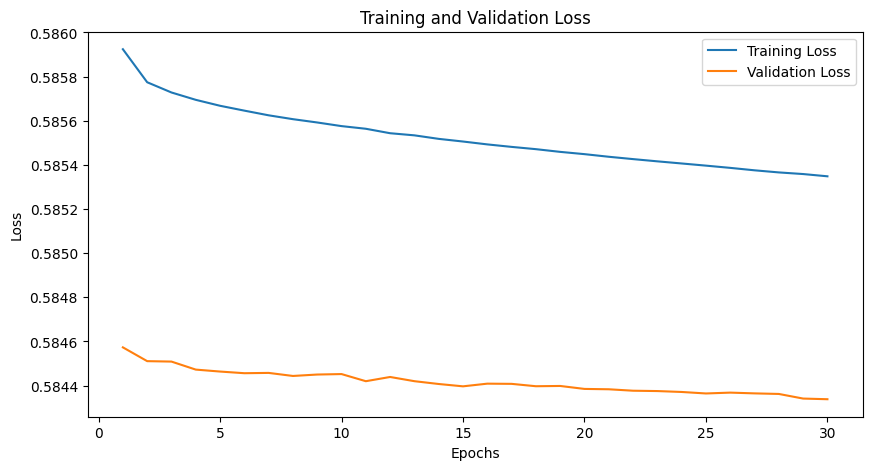

In [20]:
training(30, 0.0001)

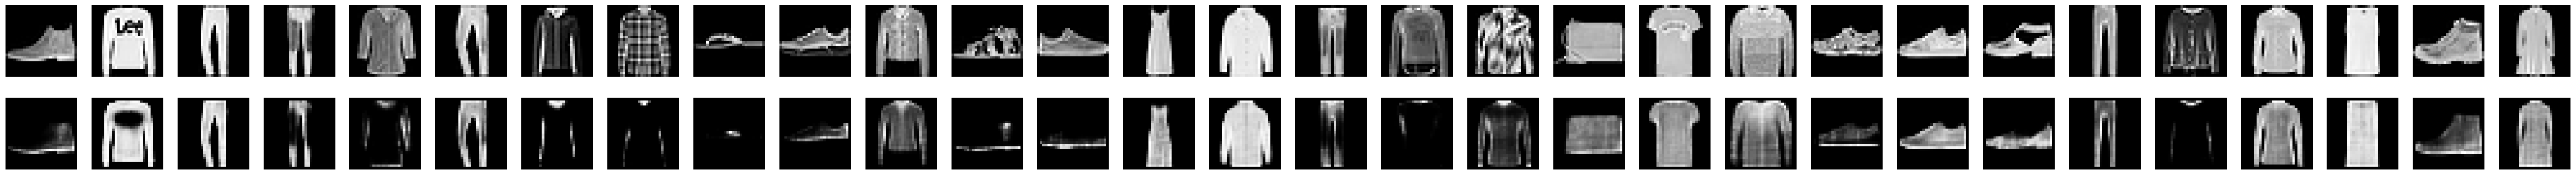

In [21]:
visualize_results(model, testloader, 30)

In [22]:
torch.save(model.state_dict(), "image_compression_autoencoder.pt")
model.load_state_dict(torch.load("image_compression_autoencoder.pt"))

<All keys matched successfully>